In [13]:
from collections import OrderedDict
import re
import os
from pathlib import Path

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
from plot_utils import get_model_names_for_degree
from collections import namedtuple

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_run_metrics_simple, get_config
from plot_utils import basic_plot, collect_results, relevant_model_names, basic_plot_simple

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

models_dir = Path("../models")
device = "cpu" # Set to "cuda" if needed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = read_run_dir(models_dir)
df  # list all the runs in our run_dir

['chebyshev_linear_regression_toy' 'curriculum' 'lora_testing_degree'
 'lora_testing_shared_roots' 'prompting_degree' 'prompting_shared_roots']
                                 run_id                      task  \
3                   small-1-11-5M-steps  kernel_linear_regression   
2                                model1  kernel_linear_regression   
4                                   old  kernel_linear_regression   
5  7f3d8135-fcb1-4f82-bed6-041508e56589                      lora   
6  f214d84d-3dad-4326-aa86-5dd04b09ae53                      lora   
0  49c6a6c8-435d-4096-a5a9-45d86c10fd23            soft_prompting   
1  6da1d7cd-bc48-4b91-9809-c0e0e59ecd06            soft_prompting   

                       model  \
3          Transformer-small   
2           Transformer-plus   
4           Transformer-plus   
5        lora_testing_degree   
6  lora_testing_shared_roots   
0           prompting_degree   
1     prompting_shared_roots   

                                              

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
3,small-1-11-5M-steps,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
2,model1,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,curriculum
4,old,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,curriculum
5,7f3d8135-fcb1-4f82-bed6-041508e56589,lora,lora_testing_degree,basis_dim=5_different_degrees=False_highest_de...,-1,-1,1,6,4,lora_testing_degree
6,f214d84d-3dad-4326-aa86-5dd04b09ae53,lora,lora_testing_shared_roots,basis_dim=5_degree=5,-1,-1,1,6,4,lora_testing_shared_roots
0,49c6a6c8-435d-4096-a5a9-45d86c10fd23,soft_prompting,prompting_degree,basis_dim=5_different_degrees=False_highest_de...,-1,-1,1,6,4,prompting_degree
1,6da1d7cd-bc48-4b91-9809-c0e0e59ecd06,soft_prompting,prompting_shared_roots,basis_dim=5_degree=5,-1,-1,1,6,4,prompting_shared_roots


../models/lora/7f3d8135-fcb1-4f82-bed6-041508e56589/config.yaml
../models/soft_prompting/49c6a6c8-435d-4096-a5a9-45d86c10fd23/config.yaml
../models/kernel_linear_regression/small-1-11-5M-steps/config.yaml


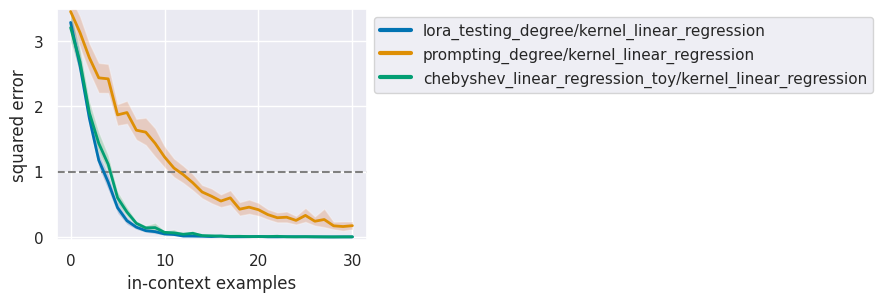

In [26]:
load_info = namedtuple("load_info", ["path", "step"])
def plot_collection(load_info_collection, device="cuda", alternative_train_conf_path=None):

    metrics = {}
    for path, step in load_info_collection:
        conf = get_config(path / "config.yaml")
        metrics[conf.wandb.name + "/" + conf.training.task] = get_run_metrics_simple(path, step=step, include_noise=False, device=device, 
                                                                                    alternative_train_conf_path=alternative_train_conf_path)

    basic_plot_simple(metrics)
    plt.show()

load_info_collection = [ load_info(path=models_dir / "lora" / "7f3d8135-fcb1-4f82-bed6-041508e56589", step=4000),
                         load_info(path=models_dir / "soft_prompting" / "49c6a6c8-435d-4096-a5a9-45d86c10fd23", step=4000),
                         load_info(path=models_dir / "kernel_linear_regression" / "small-1-11-5M-steps", step=5000000)]

plot_collection(load_info_collection, device=device, alternative_train_conf_path=load_info_collection[0].path / "config.yaml")
    
    